In [1]:
import numpy as np
root = '../../'
caffe_root = root + 'caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import os
import random

In [2]:
DATA_DIR='../../dataset/Viper/VIPeR/'
file_list_a=os.listdir(DATA_DIR+'cam_a/')
file_list_b=os.listdir(DATA_DIR+'cam_b/')

In [3]:
name_dict={}

for name in file_list_a:
    if name[-3:]=='bmp':
        id = name.split('_')[0]
        if name_dict.has_key(id):
            print 'error'
        else:
            name_dict[id]=[]
        name_dict[id].append(DATA_DIR+'cam_a/' + name)  
for name in file_list_b:
    if name[-3:]=='bmp':
        id = name.split('_')[0]
        if name_dict.has_key(id):
            name_dict[id].append(DATA_DIR+'cam_b/' + name) 
        else:
            print 'error'
print len(name_dict)


632


In [4]:
# choose test ids:
test_id_number = 316
set_no = 1
phase = 'test'
filename_test = '../../dataset/Viper/exp_set/testid%03d_set%02d_%s.txt'%(test_id_number,(set_no),phase)
print filename_test

file_object = open(filename_test)
try:
    all_the_text = file_object.read( )
finally:
    file_object.close( )

test_dict = {}

lines = all_the_text.split('\n')
for filename in lines:
    if filename!='':
        if name_dict.has_key(filename):
            test_dict[filename] = name_dict[filename]
print len(test_dict)

../../dataset/Viper/exp_set/testid316_set01_test.txt
316


In [5]:
def readList(name_list,name_dict): 
    import random
    import os
    probes=[]
    gallerys=[]
    
    for key in name_list:
        probes.append(name_dict[key][0])
        gallerys.append(name_dict[key][1])
    if len(probes)!=len(gallerys):
        print('something wrong! list length does not match!/n')
        return 0
    else:
        return probes,gallerys
def generateScoreList(net,probes,gallerys):
    transformer = caffe.io.Transformer({'data': (net.blobs['data'].data.shape)})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_mean('data', np.array([ 104.00698793,  116.66876762,  122.67891434])) # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
    
    scoreList=[]
    N,C,H,W=net.blobs['data'].data.shape
    from time import clock
    start=clock()
    #galleryData is same for each probe
    galleryLen=len(gallerys)
    galleryDataList=[]
    for galleryIdx in range(galleryLen):
        galleryName=gallerys[galleryIdx]
        galleryImage=transformer.preprocess('data', caffe.io.load_image(galleryName))
        galleryDataList.append(galleryImage)
        galleryIdx+=1
    #galleryData and probeData
    galleryData=np.asarray(galleryDataList)
    probeData=np.zeros((galleryLen,C,H,W))
    
    net.blobs['data'].reshape(galleryLen,C,H,W)
    net.blobs['data_p'].reshape(galleryLen,C,H,W)
    #process each probe
    for probeIdx in range(len(probes)):
        probeName=probes[probeIdx]
        probeImage=transformer.preprocess('data', caffe.io.load_image(probeName))
        #batch data assignment
        probeData[:,:,:,:]=probeImage
        net.blobs['data'].data[:] = probeData
        net.blobs['data_p'].data[:] = galleryData
        #net forwad
        net.forward()
        #get output score
        outScore=net.blobs['softmax_score'].data[:,(0,1)]    #softmax_score[0] and softmax_score[1]
        score_sum=np.exp(outScore[:,0]*1.0)+np.exp(outScore[:,1]*1.0)
        similarScore=outScore[:,1]#np.exp(outScore[:,1]*1.0)/score_sum
        #scoreList.append each probe score
        scoreList.append(similarScore.tolist())
        if (probeIdx+1)%10==0:
            sys.stdout.write('\r%3d/%d, '%(probeIdx+1,len(probes))+probeName)
            sys.stdout.flush()
    #we get scoreList, then cal predictLists
    predictLists=[]
    for score in scoreList:
        probeRankList=np.argsort(score)[::-1]
        predictLists.append(probeRankList)
    finish=clock()
    print('\r  Processing %dx%d pairs cost %f second time'%(len(probes),len(gallerys),(finish-start)))
    return scoreList,predictLists

def calCMC(net,set_no,rand_times=10):
    from cmc import evaluateCMC


    #rand 10 times for stable result
    cmc_list=[]
    for i in range(rand_times):
        print 'Round %d with rand list:'%i
        probes,gallerys=readList(list_name)
        scoreList,predictLists=generateScoreList(net,probes,gallerys)
        gtLabels=range(len(probes))
        cmc=evaluateCMC(gtLabels,predictLists)
        cmc_list.append(cmc)
    return np.average(cmc_list,axis=0)

In [6]:
MODEL_FILE = '../../experiments/reid_earlyfusion_google_bigmap/set01/deploy.prototxt'
PRETRAINED = '../../experiments/reid_earlyfusion_google_bigmap_cuhk03market/set01/Snapshots/set01_google_iter_30000.caffemodel'
caffe.set_device(1)
caffe.set_mode_gpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,caffe.TEST)

In [7]:
key_list = []
for key in test_dict.keys():
    key_list.append(key)

key_list_shuffle = key_list[:]
random.shuffle(key_list_shuffle)
probes,gallerys=readList(key_list_shuffle[:],test_dict)
print len(key_list)


316


In [8]:
from cmc import evaluateCMC
cmcDict = {}

In [9]:
cmc_list=[]
for i in range(3):
    print 'Round %d with rand list:'%i
    key_list_shuffle = key_list[:]
    random.shuffle(key_list_shuffle)
    probes,gallerys=readList(key_list_shuffle[:316],name_dict)
    scoreList,predictLists=generateScoreList(net,probes,gallerys)
    gtLabels=range(len(probes))
    cmc=evaluateCMC(gtLabels,predictLists)
    cmc_list.append(cmc)

Round 0 with rand list:
  Processing 316x316 pairs cost 155.086121 second time
Round 1 with rand list:
  Processing 316x316 pairs cost 159.837339 second time
Round 2 with rand list:
  Processing 316x316 pairs cost 158.775268 second time


In [10]:
print np.average(cmc_list,axis=0)

[ 0.21518987  0.28481013  0.33227848  0.37658228  0.40822785  0.42721519
  0.44936709  0.47468354  0.48734177  0.50632911  0.52848101  0.5443038
  0.55696203  0.57594937  0.59493671  0.60759494  0.61708861  0.62341772
  0.63291139  0.63607595  0.63607595  0.64240506  0.65506329  0.66772152
  0.6835443   0.6835443   0.68987342  0.69620253  0.69620253  0.7056962
  0.71202532  0.71518987  0.71518987  0.7278481   0.7278481   0.74367089
  0.75316456  0.76582278  0.77531646  0.77848101  0.78164557  0.78797468
  0.78797468  0.78797468  0.79746835  0.79746835  0.79746835  0.81012658
  0.8164557   0.8164557   0.8164557   0.82278481  0.82278481  0.82278481
  0.82594937  0.83227848  0.83227848  0.83544304  0.83860759  0.84177215
  0.84493671  0.84493671  0.84493671  0.84810127  0.85126582  0.85126582
  0.85443038  0.86075949  0.86392405  0.87025316  0.87025316  0.87025316
  0.87341772  0.87658228  0.88607595  0.88607595  0.88607595  0.88607595
  0.88607595  0.89556962  0.89556962  0.89873418  0.9

In [15]:
cmcDict = {}

In [16]:
cmcDict['ours (GN, hnm)'] = np.average(cmc_list,axis=0)

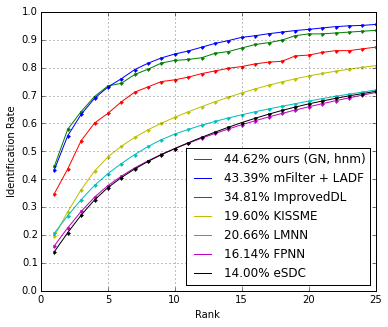

In [19]:
import scipy.io as sio
data = sio.loadmat('/mnt/share/Temp/reid_mat/VIPER.mat')['data']
from eval_cuhk03 import plotCMC

cmcDict['ImprovedDL'] = data[0]/100
cmcDict['KISSME'] = data[11]/100
cmcDict['eSDC'] = data[2]/100
#cmcDict['SDALF'] = data[3]
#cmcDict['LDM'] = data[4]/100
#cmcDict['RANK'] = data[5]
cmcDict['LMNN'] = data[6]/100
#cmcDict['ITML'] = data[7]
#cmcDict['Euclid'] = data[8]
cmcDict['FPNN'] = data[9]/100
cmcDict['mFilter + LADF'] = data[17]/100
#plot the dictionary, sorted by rank1 rate

save_path = 'VIPER_set01.png'
plotCMC(cmcDict,save_path)

In [46]:
import pickle
cmcDict_bk = cmcDict
f1 = open("res_viper.txt","wb")
pickle.dump(cmcDict, f1)
f1.close()

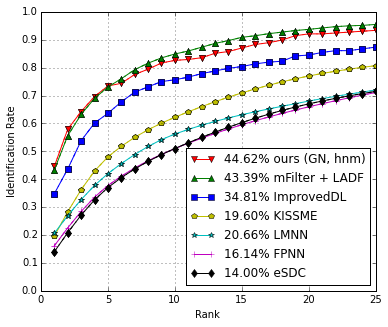

In [45]:
def plotCMC(cmcDict,pathname):
    import matplotlib.pyplot as plt
    get_ipython().magic(u'matplotlib inline')   
    from matplotlib.legend_handler import HandlerLine2D
    import numpy as np

    #plot the cmc curve, record CVPR from the pdf paper.cmc[0,4,8,12,16,21,25,29,33,37,41,45,49]
    rank2show=25
    rankStep=1
    cmcIndex=np.arange(0,rank2show,rankStep)   #0,5,10,15,20,25

    colorList=['rv-','g^-','bs-','yp-','c*-','m+-','kd-','gs-','b^-']
    #start to plot
    plt.ioff()
    fig = plt.figure(figsize=(6,5),dpi=180)
    sortedCmcDict = sorted(cmcDict.items(), key=lambda (k, v): v[1])[::-1]
    for idx in range(len(sortedCmcDict)):
        cmc_dictList=sortedCmcDict[idx]
        cmc_name=cmc_dictList[0]
        cmc_list=cmc_dictList[1]
        #print cmc_name,": ",cmc_list
        #x for plot
        x_point=[item+1 for item in cmcIndex]
        x_line=range(rank2show)
        x_plot=[temp+1 for temp in x_line]
        #start plot
        plt.plot(x_plot, cmc_list[x_line],colorList[idx],label="%02.02f%% %s"%(100*cmc_list[0],cmc_name))
        plt.plot(x_point,cmc_list[cmcIndex],colorList[idx]+'.')
        #plt.legend(loc=4,handler_map={line: HandlerLine2D(numpoints=1)})
        #idx of color +1
        idx+=1
    #something to render

    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.xticks(np.arange(0,rank2show+1,5))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.grid()
    plt.legend(loc=4)
    plt.savefig(pathname)
    plt.show()
plotCMC(cmcDict,save_path)

In [ ]:
def plotCMC_step5(cmcDict,pathname):
    import matplotlib.pyplot as plt
    get_ipython().magic(u'matplotlib inline')   
    from matplotlib.legend_handler import HandlerLine2D
    import numpy as np

    #plot the cmc curve, record CVPR from the pdf paper.cmc[0,4,8,12,16,21,25,29,33,37,41,45,49]
    rank2show=25
    rankStep=1
    cmcIndex=np.arange(0,rank2show,rankStep)   #0,5,10,15,20,25

    colorList=['rv-','g^-','bs-','yp-','c*-','m+-','kd-','gs-','b^-']
    #start to plot
    plt.ioff()
    fig = plt.figure(figsize=(6,5),dpi=180)
    sortedCmcDict = sorted(cmcDict.items(), key=lambda (k, v): v[1])[::-1]
    for idx in range(len(sortedCmcDict)):
        cmc_dictList=sortedCmcDict[idx]
        cmc_name=cmc_dictList[0]
        cmc_list=cmc_dictList[1]
        #print cmc_name,": ",cmc_list
        #x for plot
        x_point=[item+1 for item in cmcIndex]
        x_line=range(rank2show)
        x_plot=[temp+1 for temp in x_line]
        #start plot
        plt.plot(x_plot, cmc_list[x_line],colorList[idx],label="%02.02f%% %s"%(100*cmc_list[0],cmc_name))
        plt.plot(x_point,cmc_list[cmcIndex],colorList[idx]+'.')
        #plt.legend(loc=4,handler_map={line: HandlerLine2D(numpoints=1)})
        #idx of color +1
        idx+=1
    #something to render

    plt.xlabel('Rank')
    plt.ylabel('Identification Rate')
    plt.xticks(np.arange(0,rank2show+1,5))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.grid()
    plt.legend(loc=4)
    plt.savefig(pathname)
    plt.show()